In [79]:
using Distributions,Gadfly,StatsFuns,InplaceOps
include("/home/seth/code/sparse_normal_categorical/normal_probit_gibbs.jl")

n = 1000;
K = 20;
y = [rand(Poisson(0.1),div(n,2)); rand(Poisson(5),div(n,4));rand(Poisson(10),div(n,4))];
prior = Dict{Symbol,Union{Int64,Float64,Array{Float64}}}(
:K=>K,:a0=>0.5,:b0=>0.1,:theta0=>rand(Gamma(0.5,10.0),K));
hyperprior = Dict{Symbol,Float64}(:a0=>1,:b0=>1);

In [70]:
function llp(y::Int64,lambda::Float64)
    y*log(lambda) - lambda;
end

llp (generic function with 1 method)

In [91]:
@time out = psbpm(y,[],llp,sample_poisson,prior,hyperprior,0,100,50000);
out[:B] = reshape(out[:B],size(out[:B])[2:3]);

413.620646 seconds (5.28 G allocations: 109.240 GB, 2.83% gc time)


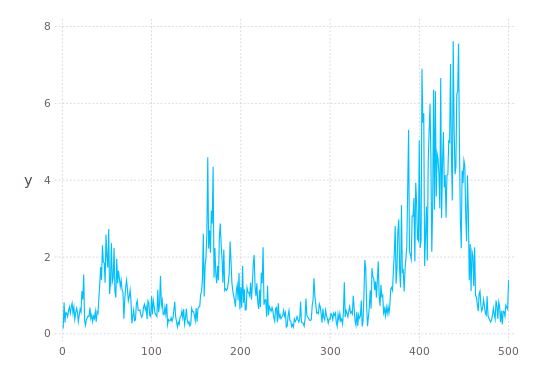

In [92]:
plot(y=out[:sigmaB0],Geom.line)

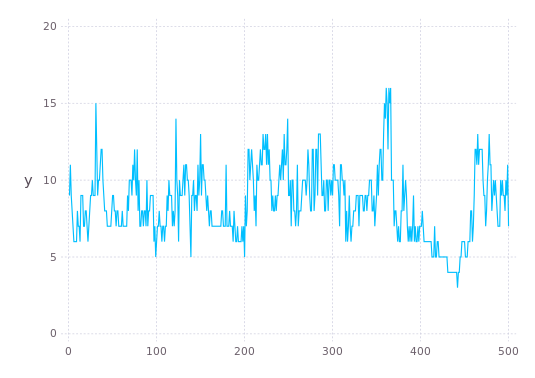

In [93]:
plot(y=mapslices(x -> length(unique(x)),out[:z],1),Geom.line)

In [95]:
foo = mapslices(x -> eta2p(ones((1,1)),x'),out[:B],1)


20x500 Array{Float64,2}:
 0.384858     0.188183     0.302155     …  0.283231     0.241003   
 0.370609     0.29363      0.348589        0.113439     0.0849334  
 0.135309     0.282443     0.200417        0.0743865    0.12506    
 0.0425009    0.116709     0.0919889       0.271144     0.328187   
 0.0401511    0.0448819    0.0441144       0.110762     0.0639732  
 0.0124273    0.0478413    0.00763064   …  0.134737     0.15474    
 0.00742718   0.0181737    0.00374354      0.00361859   0.000413593
 0.0016145    0.000939046  0.00020175      0.00398744   0.00115984 
 0.00238157   0.00372865   0.000758376     0.00218849   0.000204067
 0.00148762   0.00175597   0.000281356     0.00155024   0.000115803
 0.000211207  0.000246267  2.4566e-5    …  0.000883978  0.00016779 
 0.000169421  0.000107332  2.76862e-5      6.17941e-5   4.03331e-5 
 0.000280693  0.000610939  3.63679e-5      9.58768e-6   1.3108e-6  
 0.0001986    0.000234638  9.11775e-6      1.46493e-7   1.17338e-8 
 0.000196146  0.0002805